In [439]:
from collections import defaultdict
import os
root_folder = "model_save_dir_NER_03_16_21_16"
train_folder = "datasets"
l2L= {"tr":"Turkish","cs":"Czech","fi":"Finnish","hu":"Hungarian"}
def get_datasets(langs):
    datasets = {}
    for lang in langs :
        path = os.path.join(train_folder,"myner_{}-train.txt".format(l2L[lang].lower()))
        with open(path,"r") as f:
            x = f.read().split("\n\n")[:-1]
            datasets[lang] = [[w.split()[0] for w in y.split("\n")] for y in x]
    return datasets
def get_freqs(datasets):
    freqs = {}
    for d in datasets:
        freqs[d]=defaultdict(int)
        for sent in datasets[d]:
            for word in sent:
                if len(word)>3:
                    freqs[d][word.lower()]+=1
    return freqs
datasets = get_datasets(langs)
counts = get_freqs(datasets)
def get_ner_sentences(model_list, lang):
    """
        Finds the common sentences for each model together with predictions and labels
    """
    ner_sents = defaultdict(dict)
    for model in model_list:
        with open(os.path.join(root_folder,"NER_{}_{}_joint_ner_out.txt".format(model,lang)),"r") as f:
            sents = f.read().split("\n\n")
            for sent in sents[:-1]:
                
                tokens = sent.split("\n")
                
                key="".join([t.split()[0] for t in tokens])
                sentence = " ".join([t.split()[0] for t in tokens])
                preds = [t.split()[-1] for t in tokens]
                labels = [t.split()[-2] for t in tokens]
                success = all([p==l for p,l in zip(preds,labels)])
                ner_sents[model][key] = (sentence,preds,labels,success)
                
    return ner_sents

def find_common_sents(ner_sents):
    common_sents = []
    models = list(ner_sents.keys())

    for key in ner_sents[models[0]]:
        if all([key in ner_sents[model] for model in models]):
            common_sents.append(key)
    return common_sents

def find_tokenbased_difference(ner_sents,common_sents):
    """
        Find the sentences for which subtoken succeeded and token failed
    """
    token_diff_sents = []
    models = list(ner_sents.keys())
    for sent in common_sents:
        if all([ner_sents[model][sent][-1]==False for model in ["random_init","word2vec"]]) and ner_sents["fastext"][sent][-1]==True and ner_sents["bert"][sent][-1]==True:
            token_diff_sents.append(sent)
    return token_diff_sents

def find_bert_difference(ner_sents, common_sents, reverse=False):
    """
        Find the sentences for which subtoken succeeded and token failed
    """
    bert_diff_sents = defaultdict(list)
    models = list(ner_sents.keys())
    for sent in common_sents:
        for model in ["random_init","word2vec","fastext"]:
            if ner_sents[model][sent][-1]==reverse and ner_sents["bert"][sent][-1]!=reverse:
                bert_diff_sents[model].append(sent)
    return bert_diff_sents
def print_subword_diff(diff_sents, ner_sents,models = ["bert","random_init","word2vec"]):
    print("word\t{}\t{}\t{}\n".format(*models))
    for key in diff_sents:
        sentence = ner_sents["bert"][key][0]
        for i,word in enumerate(sentence.split()) :
            print("\t".join([word]+[ner_sents[model][key][1][i] for model in models])+"\n")
        print("\n")
        
def print_bert_diff(diff_sents, ner_sents,models = ["bert","fastext","random_init","word2vec"]):
    print("word\t{}\t{}\t{}\n".format(*models))
    for key in diff_sents:
        sentence = ner_sents["bert"][key][0]
        for i,word in enumerate(sentence.split()) :
            print("\t".join([word]+[ner_sents[model][key][1][i] for model in models])+"\n")
        print("\n")

In [654]:
model_list = ["bert","random_init","word2vec","fastext"]
unknowns = defaultdict(list)
rares =  defaultdict(list)
lengths = defaultdict(list)
all_sent_lengths = defaultdict(list)
all_multiple_tag_freqs = defaultdict(list)
all_tag_types = defaultdict(list)
sent_count = defaultdict(list)
ent_counts = defaultdict(list)
models = ["random_init","word2vec","fastext","Overall"]
for lang in ["cs","hu","fi","tr"]:
    print(l2L[lang])
    ner_sents = get_ner_sentences(model_list, lang)
    common_sents = find_common_sents(ner_sents)
    subword_diff_sents = find_tokenbased_difference(ner_sents,common_sents)
    bert_diff_sents = find_bert_difference(ner_sents,common_sents,reverse=False)
    print("BERT NER SENTS : {}".format(len(ner_sents["bert"])))
    all_unknown_freq, wrong_unknown_freq, entity_count = rare_analysis(bert_diff_sents, ner_sents,lang, rare_count = 0)
    all_rare_freq, wrong_rare_freq, _ = rare_analysis(bert_diff_sents, ner_sents,lang, rare_count = 2)
    entity_aver_lengths,sent_lengths = length_analysis(bert_diff_sents, ner_sents)
    tag_types, multiple_tag_freqs = different_tag_analysis(bert_diff_sents, ner_sents)
    for k,y in bert_diff_sents.items(): 
        print("{} failed examples of {} for {} sentences".format(len(y),k,len(common_sents)))
    for m in models[:-1]:
        sent_count[m].append(len(bert_diff_sents[m]))
    sent_count["Overall"].append(len(ner_sents["bert"]))
    for m in models:
        ent_counts[m].append(entity_count[m])

    
    for x,val in entity_aver_lengths.items():
        print("Entity Lengths. Model : {} Value : {}  Overall : {}".format(x,val,entity_aver_lengths["Overall"]))
        lengths[x].append(val)
    for x,val in tag_types.items():
        print("Tag types. Model : {} Value : {}  Overall : {}".format(x,val,tag_types["Overall"]))
        all_tag_types[x].append(val)   
    for x,val in multiple_tag_freqs.items():
        print("Multiple tag frequency. Model : {} Value : {}  Overall : {}".format(x,val,multiple_tag_freqs["Overall"]))
        all_multiple_tag_freqs[x].append(val)
    for x,val in sent_lengths.items():
        print("Sent Lengths. Model : {} Value : {}  Overall : {}".format(x,val,sent_lengths["Overall"]))
        all_sent_lengths[x].append(val)
    for x in all_rare_freq :
        print("Rare. Model : {} Value : {}  Overall : {}".format(x,wrong_rare_freq[x],all_rare_freq[x]))
        val = wrong_rare_freq[x]
        overall = all_rare_freq[x]
        rares[x].append(val)
    rares["Overall"].append(overall)
    for x in all_unknown_freq :
        val = wrong_unknown_freq[x]
        overall = all_unknown_freq[x]
        print("Unknown. Model : {}  Value : {}  Overall : {}".format(x,wrong_unknown_freq[x],all_unknown_freq[x]))
        unknowns[x].append(val)
    unknowns["Overall"].append(overall)



Czech
BERT NER SENTS : 889
random_init . Number of wrong entities : 659 Number of all entities : 2473 
word2vec . Number of wrong entities : 691 Number of all entities : 2473 
fastext . Number of wrong entities : 659 Number of all entities : 2473 
random_init . Number of wrong entities : 659 Number of all entities : 2473 
word2vec . Number of wrong entities : 691 Number of all entities : 2473 
fastext . Number of wrong entities : 659 Number of all entities : 2473 
154 failed examples of random_init for 889 sentences
164 failed examples of word2vec for 889 sentences
154 failed examples of fastext for 889 sentences
Entity Lengths. Model : random_init Value : 5.615284974093265  Overall : 5.441631504922644
Entity Lengths. Model : word2vec Value : 5.6419753086419755  Overall : 5.441631504922644
Entity Lengths. Model : fastext Value : 5.756648936170213  Overall : 5.441631504922644
Entity Lengths. Model : Overall Value : 5.441631504922644  Overall : 5.441631504922644
Tag types. Model : random

In [647]:
print_row = lambda x : print("&".join(["&".join([str(round(x[m][i],3)) for m in models]) for i,lang in enumerate(langs)]))




print_row(ent_counts)





77&80&69&2473&26&50&50&1161&284&217&254&3174&168&175&240&1667


In [641]:
print("&".join(["&".join([str(round(sent_count[m][i],3)) for m in models]) for i,lang in enumerate(langs)]))

26&27&25&889&10&13&14&933&144&115&139&3506&79&85&95&2729


In [655]:
print_row(unknowns)

0.551&0.553&0.568&0.55&0.501&0.525&0.53&0.411&0.552&0.549&0.561&0.552&0.379&0.445&0.453&0.369


In [649]:
print_row(rares)

0.636&0.625&0.667&0.736&0.423&0.58&0.5&0.597&0.433&0.424&0.409&0.701&0.423&0.429&0.45&0.525


In [651]:
print_row(all_sent_lengths)

24.423&24.926&23.76&22.487&29.5&31.385&27.571&24.119&13.896&13.209&13.223&13.41&17.608&16.518&18.6&13.162


In [652]:
print_row(lengths)

5.074&5.284&5.2&5.442&5.586&6.661&7.259&6.813&7.729&7.845&7.693&7.568&6.972&6.556&6.694&6.905


In [627]:
for i,lang in enumerate(langs):
    print("Language : {}".format(lang))
    keys = ["random_init","word2vec",'fastext','Overall']
    print("Unk")
    print("&".join([str(round(unknowns[m][i],3)) for m in keys]))
    print("Rare")
    print("&".join([str(round(rares[m][i],3)) for m in keys]))
    print("Token lengths ")
    print("&".join([str(round(lengths[m][i],3)) for m in keys]))
    print("Sentence lengths ")
    print("&".join([str(round(all_sent_lengths[m][i],3)) for m in keys]))

Language : tr
Unk
0.304&0.309&0.312&0.369
Rare
0.423&0.429&0.45&0.525
Token lengths 
6.972&6.556&6.694&6.905
Sentence lengths 
17.608&16.518&18.6&13.162
Language : cs
Unk
0.519&0.412&0.507&0.55
Rare
0.636&0.625&0.667&0.736
Token lengths 
5.074&5.284&5.2&5.442
Sentence lengths 
24.423&24.926&23.76&22.487
Language : fi
Unk
0.352&0.341&0.319&0.552
Rare
0.433&0.424&0.409&0.701
Token lengths 
7.729&7.845&7.693&7.568
Sentence lengths 
13.896&13.209&13.223&13.41
Language : hu
Unk
0.346&0.4&0.34&0.411
Rare
0.423&0.58&0.5&0.597
Token lengths 
5.586&6.661&7.259&6.813
Sentence lengths 
29.5&31.385&27.571&24.119


In [553]:
length_analysis()

defaultdict(list,
            {'random_init': [0.3793103448275862,
              0.5508345978755691,
              0.5518134715025906,
              0.5007949125596184],
             'word2vec': [0.4447852760736196,
              0.552821997105644,
              0.5487274984481688,
              0.5245398773006135],
             'fastext': [0.4533551554828151,
              0.56752655538695,
              0.5605867346938775,
              0.5297619047619048],
             'Overall': [0.36892621475704857,
              0.5503437120905782,
              0.5519848771266541,
              0.4108527131782946]})

In [558]:
def modelwise_analysis_plotter(modelwise_data, y_label, save_name, label=True):
    models = [] 
    l = len(modelwise_data)
    width = 1.5
    bar_width = 0.25
    X = np.linspace(0,l*width,l)
    fig, ax = plt.subplots()
    for i, model in enumerate(modelwise_data.keys()):
        data = modelwise_data[model]
        x = X -((l-1)*bar_width)/2+i*bar_width 
        ax.bar(x, data, width = bar_width,label=model[0].upper() + model[1:] if model!="random_init" else "Baseline")
    ax.set_xticks(X)
    ax.set_ylabel(y_label)
    ax.set_xticklabels([l2L[l] for l in langs])
    if label: 
        ax.legend(loc=4)
    plt.tight_layout()
    fig.savefig(save_name)
    plt.show()

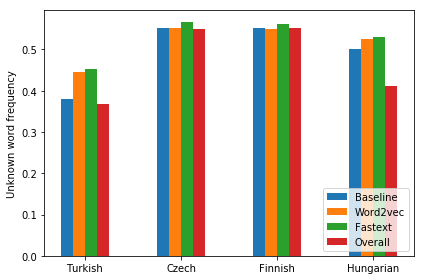

In [559]:
modelwise_analysis_plotter(unknowns,"Unknown word frequency","unk",label=True)

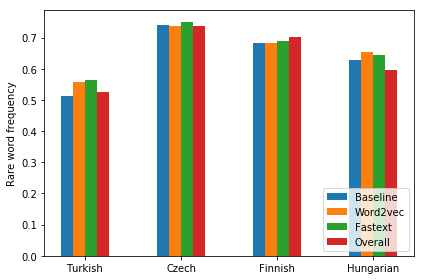

In [561]:
modelwise_analysis_plotter(rares,"Rare word frequency","unk",label=True)

In [629]:
def rare_analysis(diff_sents, ner_sents, lang, rare_count = 5):
    """
        Frequency of tokens for which at least one token-based model failed to find the correct value.
    """
    avg_all_entities = defaultdict(int)
    avg_wrong_entities = defaultdict(int)
    entity_count = defaultdict(int)
    all_entities = set()
    for sent in ner_sents["bert"]:
        sentence = ner_sents["bert"][sent][0].split()
        labels = ner_sents["bert"][sent][1]
        for word,label in zip(sentence,labels):
            if label !="O":
                all_entities.add(word.lower())
    for model,sents in diff_sents.items():
        wrong_entities = set()
        for sent in sents:
            for i, label in enumerate(ner_sents["bert"][sent][1]):
                word = ner_sents["bert"][sent][0].split()[i]
                if label != "O":
                    wrong_entities.add(word.lower())
        
        print("{} . Number of wrong entities : {} Number of all entities : {} ".format(model, len(wrong_entities),len(all_entities)))
        average_occurrence_all_entities = sum([1 if counts[lang][word] <= rare_count else 0 for word in all_entities])/len(all_entities)
        average_occurrence_wrong_entities = sum([1 if counts[lang][word] <= rare_count else 0 for word in wrong_entities])/len(wrong_entities)
        avg_all_entities[model] = average_occurrence_all_entities
        avg_wrong_entities[model] = average_occurrence_wrong_entities
        entity_count[model] = len(wrong_entities)
    entity_count["Overall"] = len(all_entities)
    return avg_all_entities, avg_wrong_entities, entity_count




In [169]:
def suffix_analysis(suff, diff_sents, ner_sents, models1=["bert","fastext"], models2=["random_init","word2vec"]):
    """
        Count the number of tokens for which at least one token-based model failed to find the correct value.
    """
    wrong_count = 0
    suff_wrong_count = 0
    for sent in diff_sents:
        for i, label in enumerate(ner_sents["bert"][sent][1]):
            word = ner_sents["bert"][sent][0].split()[i]
            if label != "O" and any([ner_sents[model][sent][1][i]!=label for model in models2]):
                wrong_count += 1
                if suff in word:
                    suff_wrong_count += 1
    total_ents = 0
    total_suff = 0
    for sent in ner_sents["bert"]:
        sentence = ner_sents["bert"][sent][0].split()
        labels = ner_sents["bert"][sent][1]
        for word,label in zip(sentence,labels):
            if label !="O":
                total_ents += 1
                if suff in word :
                    total_suff += 1
    return suff_wrong_count, wrong_count,total_suff, total_ents

## Suffix Analysis

We check the sentences for which all models except bert failed.

Observation : 

- We observed that many of the wrong predictions contained apostrophe (with at least one suffix)
- The ratio of  entity-with-suffix / entities  is much higher among the wrong predictions of the token-based systems

In [170]:
suff_wrong_count, wrong_count,total_suff, total_ents = suffix_analysis("'",bert_diff_sents,ner_sents)

In [171]:
suff_wrong_count, wrong_count, total_suff, total_ents

(140, 247, 1162, 3775)

In [579]:
def length_analysis(diff_sents, ner_sents):
    """
        Length of tokens for which at least one token-based model failed to find the correct value.
    """
    all_lengths = []
    entity_aver_lengths = defaultdict(int)
    sent_lengths = defaultdict(int)
    for sent in ner_sents["bert"]:
        sentence = ner_sents["bert"][sent][0].split()
        labels = ner_sents["bert"][sent][1]
        for word,label in zip(sentence,labels):
            if label !="O":
                all_lengths.append(len(word))
    all_aver = sum(all_lengths)/len(all_lengths)
    for model,sents in diff_sents.items():
        wrong_lengths = []
        for sent in sents:
            for i, label in enumerate(ner_sents["bert"][sent][1]):
                word = ner_sents["bert"][sent][0].split()[i]
                if label != "O" :
                    wrong_lengths.append(len(word))
        sent_lengths[model] = sum([len(ner_sents["bert"][x][0].split()) for x in sents])/len(sents)
        wrong_aver = sum(wrong_lengths)/len(wrong_lengths)
        entity_aver_lengths[model] = wrong_aver
    entity_aver_lengths["Overall"] = all_aver
    sent_lengths["Overall"] = sum([len(ner_sents["bert"][sent][0].split()) for sent in ner_sents["bert"]])/len(ner_sents["bert"])
    return entity_aver_lengths, sent_lengths

## Length of Words Analysis

We compare the length of wrong predictions with all entities

Observation :  Average of all tokens is a lot smaller than long words !  


In [173]:
wrong_aver, all_aver = length_analysis(bert_diff_sents, ner_sents)
wrong_aver, all_aver

(8.178137651821862, 6.905430463576159)

In [601]:
def frequency_analysis(diff_sents, ner_sents,lang):
    """
        Frequency of tokens for which at least one token-based model failed to find the correct value.
    """
    avg_all_entities = defaultdict(int)
    avg_wrong_entities = defaultdict(int)

    for model,sents in diff_sents.items():
        wrong_entities = set()
        all_entities = set()
        for sent in sents:
            for i, label in enumerate(ner_sents["bert"][sent][1]):
                word = ner_sents["bert"][sent][0].split()[i]
                if label != "O":
                    wrong_entities.add(word)
        for sent in ner_sents["bert"]:
            sentence = ner_sents["bert"][sent][0].split()
            labels = ner_sents["bert"][sent][1]
            for word,label in zip(sentence,labels):
                if label !="O":
                    all_entities.add(word)
        average_occurrence_all_entities = sum([counts[lang][word]for word in all_entities])/len(all_entities)
        average_occurrence_wrong_entities = sum([counts[lang][word]for word in wrong_entities])/len(wrong_entities)
        avg_all_entities[model] = average_occurrence_all_entities
        avg_wrong_entities[model] = average_occurrence_wrong_entities
    return avg_all_entities, avg_wrong_entities




## # of Occurrence Analysis

We compare the length of wrong predictions with all entities

Observation :  Frequency of wrong predictions


In [353]:
average_occurrence_all_entities, average_occurrence_wrong_entities = frequency_analysis(bert_diff_sents, ner_sents)

TypeError: frequency_analysis() missing 1 required positional argument: 'lang'

In [166]:
average_occurrence_all_entities, average_occurrence_wrong_entities

(2.212778429073857, 2.1745283018867925)

In [599]:
def different_tag_analysis(diff_sents, ner_sents):
    """
        Length of tokens for which at least one token-based model failed to find the correct value.
    """
    all_tag_types = defaultdict(set)
    wrong_tag_types = {}
    multiple_tag_freqs = {}
    for model,sents in diff_sents.items():
        wrong_tags = defaultdict(set)
        for sent in sents : 
            for i, label in enumerate(ner_sents["bert"][sent][1]):
                word = ner_sents["bert"][sent][0].split()[i]
                wrong_tags[word.lower()].add(label)
        wrong_tags_new = []
        for k,v in wrong_tags.items():
            if len(v)>1 or list(v)[0]!="0":
                wrong_tags_new.append(len(v))
        wrong_tag_types[model] = sum(wrong_tags_new)/len(wrong_tags_new)
        multiple_tag_freqs[model] = sum([1 if w>1 else 0 for w in wrong_tags_new])/len(wrong_tags_new)
    for sent in ner_sents["bert"]:
        sentence = ner_sents["bert"][sent][0].split()
        labels = ner_sents["bert"][sent][1]
        for word,label in zip(sentence,labels):
            all_tag_types[word].add(label)
    all_entities_new = []
    for k,v in all_tag_types.items():
        if len(v)>1 or list(v)[0]!="0":
            all_entities_new.append(len(v))
    multiple_tag_freqs["Overall"] = sum([1 if w>1 else 0 for w in all_entities_new])/len(all_entities_new)
    wrong_tag_types["Overall"] = sum(all_entities_new)/len(all_entities_new)
    return wrong_tag_types, multiple_tag_freqs

## # of Tags Analysis

We compare the number of different tags for each entity

Observation :  BERT performed better on entities with more labels


In [183]:
aver_tag_type, aver_wrong_tag_type = different_tag_analysis(bert_diff_sents, ner_sents)
aver_tag_type, aver_wrong_tag_type 

(1.0287221570926144, 1.0636363636363637)

In [330]:
list(map(lambda x : len(x[1]),datasets.items()))

[25513, 7142, 15427, 7688]

In [229]:
def sentence_length_analysis(diff_sents, ner_sents, models1=["bert","fastext"],models2=["random_init","word2vec"]):
    """
        Length of tokens for which at least one token-based model failed to find the correct value.
    """
    wrong_lengths = []
    all_lengths = []
    for sent in diff_sents:
        sentence = ner_sents["bert"][sent][0].split()
        wrong_lengths.append(len(sentence))
    for sent in ner_sents["bert"]:
        sentence = ner_sents["bert"][sent][0].split()
        all_lengths.append(len(sentence))
    wrong_length = sum(wrong_lengths)/len(wrong_lengths)
    all_length = sum(all_lengths)/len(all_lengths)
    return wrong_length, all_length

In [232]:
def is_title_analysis(diff_sents, ner_sents, models1=["bert","fastext"],models2=["random_init","word2vec"]):
    """
        Length of tokens for which at least one token-based model failed to find the correct value.
    """
    wrong_entities = set()
    all_entities = defaultdict(int)
    for sent in diff_sents:
        for i, label in enumerate(ner_sents["bert"][sent][1]):
            word = ner_sents["bert"][sent][0].split()[i]
            if label != "O" and any([ner_sents[model][sent][1][i]!=label for model in models2]):
                wrong_entities.add(word)
    for sent in ner_sents["bert"]:
        sentence = ner_sents["bert"][sent][0].split()
        labels = ner_sents["bert"][sent][1]
        for word,label in zip(sentence,labels):
            if label !="O":
                all_entities[word] = 1 if word[0].istitle() or word.isupper() else 0
    aver_caps_frequency = sum([v for v in all_entities.values()])/len(all_entities)
    aver_wrong_caps_frequency = sum([all_entities[wrong] for wrong in wrong_entities])/len(wrong_entities)
#     for wrong in wrong_entities: 
#         print(wrong, all_entities[wrong])
    return aver_caps_frequency, aver_wrong_caps_frequency

In [362]:
import matplotlib.pyplot as plt
import numpy as np

word_lengths = [[],[]]
sentence_lengths = [[],[]]
tag_types = [[],[]]
freqs = [[],[]]
langs = ["tr","cs","fi","hu"]
for lang in langs:
    model_list = ["bert","fastext","random_init","word2vec"]
    ner_sents = get_ner_sentences(model_list, lang)
    common_sents = find_common_sents(ner_sents)
    subword_diff_sents = find_tokenbased_difference(ner_sents,common_sents)
    bert_diff_sents = find_bert_difference(ner_sents,common_sents)
    print("Lang {}".format(lang))
    print("{} unique bert corrects for {} sentences".format(len(bert_diff_sents),len(common_sents)))
    print("{} unique subword corrects for {} sentences".format(len(subword_diff_sents),len(common_sents)))
    suff_wrong_count, wrong_count,total_suff, total_ents = suffix_analysis("'",bert_diff_sents,ner_sents)
    suff_wrong_freq = suff_wrong_count/ wrong_count
    suff_total_freq = total_suff / total_ents
    wrong_aver, all_aver = length_analysis(bert_diff_sents, ner_sents)
    average_occurrence_all_entities, average_occurrence_wrong_entities = frequency_analysis(bert_diff_sents, ner_sents,lang)
    aver_tag_type, aver_wrong_tag_type = different_tag_analysis(bert_diff_sents, ner_sents)
    aver_caps_frequency, aver_wrong_caps_frequency = is_title_analysis(bert_diff_sents, ner_sents)
    wrong_length, all_length = sentence_length_analysis(bert_diff_sents, ner_sents)
    word_lengths[0].append(wrong_aver)
    word_lengths[1].append(all_aver)
    tag_types[0].append(aver_wrong_tag_type)
    tag_types[1].append(aver_tag_type)
    sentence_lengths[0].append(wrong_length)
    sentence_lengths[1].append(all_length)
    freqs[0].append(average_occurrence_wrong_entities)
    freqs[1].append(average_occurrence_all_entities)
    print("\nApostrophe analysis")
    print("Frequency of entities with apostrophe. All entities : {}   Wrongs : {}\n ".format(suff_total_freq, suff_wrong_freq))
    print("Length analysis")
    print("Average length of entities. All entities : {}   Wrongs : {} \n".format(all_aver, wrong_aver))
    print("# of occurrence analysis")
    print("Average occurence of entities. All entities : {}   Wrongs : {} \n".format(average_occurrence_all_entities, average_occurrence_wrong_entities))
    print("Tag type analysis")
    print("Average number of tags. All entities : {}   Wrongs : {}\n ".format(aver_tag_type, aver_wrong_tag_type))
    print("Caps analysis")
    print("Average number of entities with capitalization. All entities : {}   Wrongs : {}\n ".format(aver_caps_frequency, aver_wrong_caps_frequency))
    print("Sentence length analysis")
    print("Average length of sentences. All sentences : {}   Wrongs : {}\n ".format(all_length, wrong_length))
   


Lang tr
151 unique bert corrects for 2729 sentences
34 unique subword corrects for 2729 sentences
Number of wrong entities 212 Number of all entities 1706 

Apostrophe analysis
Frequency of entities with apostrophe. All entities : 0.30781456953642383   Wrongs : 0.5668016194331984
 
Length analysis
Average length of entities. All entities : 6.905430463576159   Wrongs : 8.178137651821862 

# of occurrence analysis
Average occurence of entities. All entities : 10.762602579132473   Wrongs : 7.061320754716981 

Tag type analysis
Average number of tags. All entities : 1.0287221570926144   Wrongs : 1.0613207547169812
 
Caps analysis
Average number of entities with capitalization. All entities : 0.9923798358733881   Wrongs : 1.0
 
Sentence length analysis
Average length of sentences. All sentences : 13.162330524001465   Wrongs : 18.344370860927153
 
Lang cs
124 unique bert corrects for 889 sentences
13 unique subword corrects for 889 sentences
Number of wrong entities 317 Number of all entitie

In [378]:

def analysis_plotter(data,y_label,save_name,label=True):
    X = np.arange(len(data[0]))
    fig, ax = plt.subplots()
    ax.bar(X -.125, data[0], width = 0.25,label='Others failed')
    ax.bar(X +.125, data[1],  width = 0.25,label='All sentences')
    ax.set_xticks(X)
    ax.set_ylabel(y_label)
    ax.set_xticklabels([l2L[l] for l in langs])
    if label: 
        ax.legend(loc=9)
    plt.tight_layout()
    fig.savefig(save_name)
    plt.show()

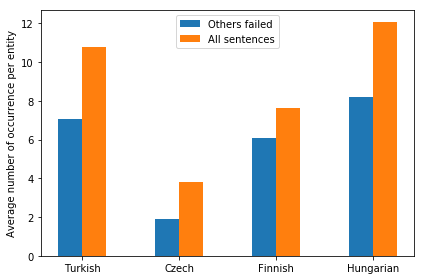

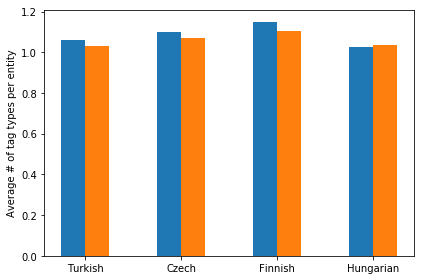

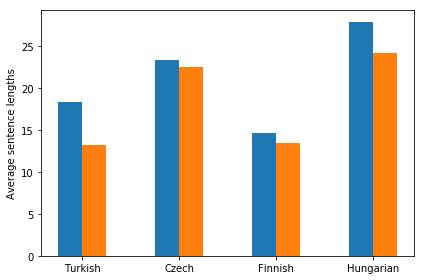

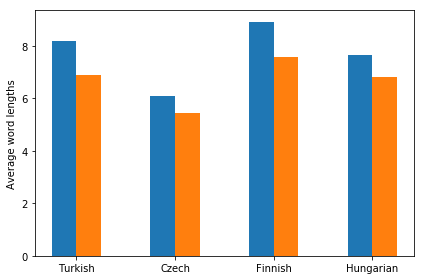

In [380]:
analysis_plotter(freqs,"Average number of occurrence per entity","freqs.png",label=True)
analysis_plotter(tag_types,"Average # of tag types per entity","ent_type.png",label=False)
analysis_plotter(sentence_lengths,"Average sentence lengths","ner_sent_lens.png",label=False)

analysis_plotter(word_lengths,"Average word lengths","ner_word_lens.png",label=False)